# Uncertainty on market shares

In [194]:
import brightway2 as bw
import bw2calc as bc
import bw2data as bd
import numpy as np
import pandas as pd
import presamples as ps
import scipy
import scipy.stats as stats
ps.__version__
import seaborn as sns
import matplotlib as mpl

In [195]:
sns.set_style("darkgrid")

In [196]:
import pandas as pd
import re

# Your cleaning function
def clean_activity_string(raw_string):
    cleaned = raw_string.replace("'", "")
    
    generic_phrase = "to generic market for transport, freight, lorry, unspecified"
    cleaned = re.sub(re.escape(generic_phrase), "", cleaned, flags=re.IGNORECASE).strip()
    
    generic_phrase = "measured as solid wood under bark"
    cleaned = re.sub(re.escape(generic_phrase), "", cleaned, flags=re.IGNORECASE).strip()

    # Step 2: Replace long-form units with abbreviations
    unit_replacements = {
        "kilogram": "kg",
        "kilograms": "kg",
        "ton kilometer": "tkm",
        "tonne kilometer": "tkm",
        "megajoule": "MJ",
        "kilowatt hour": "kWh",
        "cubic meter": "m3",
        "square meter": "m2",
        "meter": "m",
        "second": "s",
    }
    for long, short in unit_replacements.items():
        cleaned = re.sub(rf'\b{long}\b', short, cleaned, flags=re.IGNORECASE)

    # Step 3: Remove ", None" from inside parentheses
    cleaned = re.sub(r',?\s*None\s*\)', ')', cleaned)

    return cleaned

# Ecoinvent examples: simple category 

In [197]:
products_category= pd.read_csv("results/Global__categories_products.csv")

In [198]:
heatmap_data = products_category.pivot(index="names", columns="reference_product", values="mu_star_relative")

In [199]:
set(products_category['reference_product'])

{'_chromium_production___kilogram__RoW__None_',
 '_market_for_ascorbic_acid___kilogram__GLO__None_',
 '_market_for_sawnwood__board__softwood__raw__dried__u_20_____cubic_meter__CH__None_',
 '_soybean_oil_refinery_operation___kilogram__US__None_'}

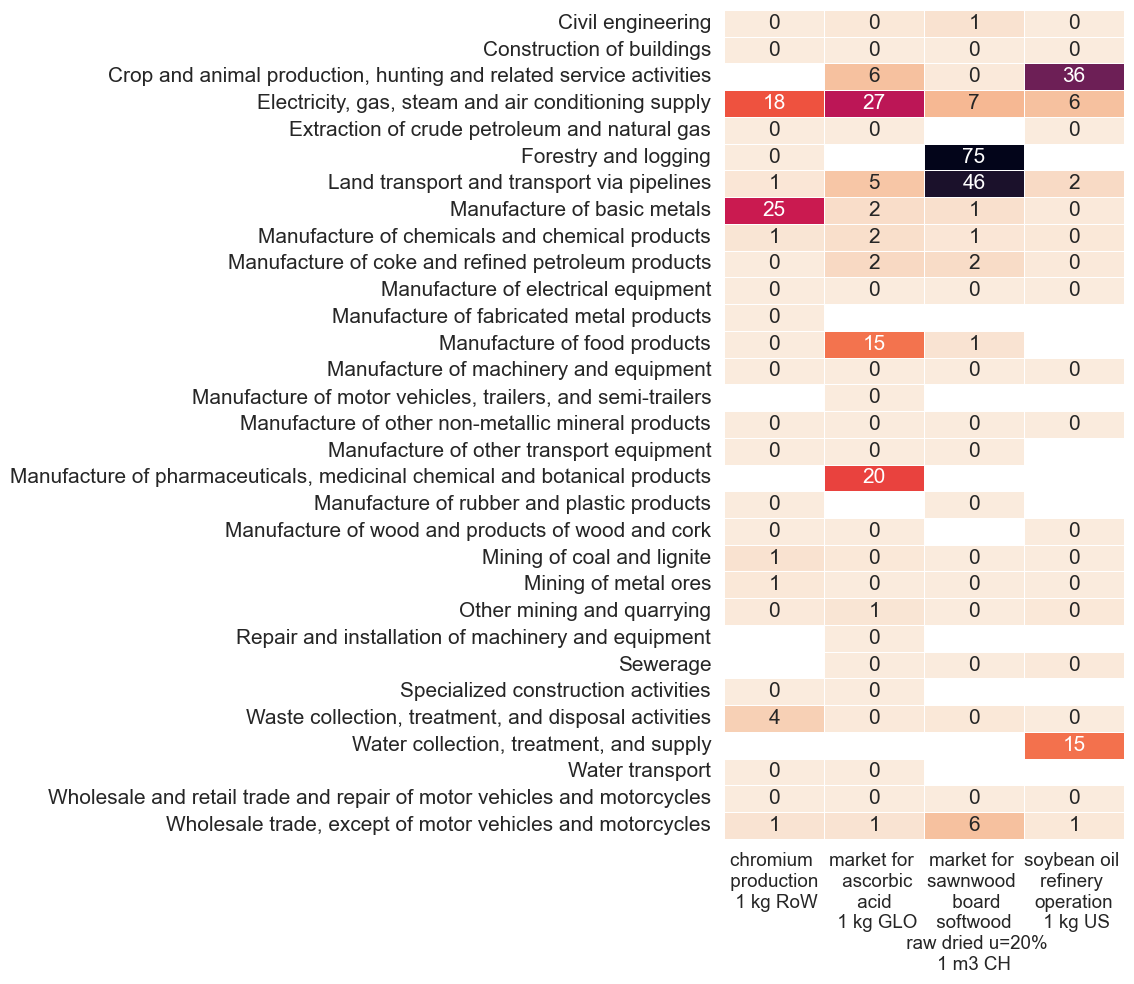

In [450]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example: custom x-axis labels
custom_x_labels = ['chromium \n production \n 1 kg RoW',
                 'market for \n ascorbic\n acid \n 1 kg GLO',
                 'market for \nsawnwood \n board\n softwood \n raw dried u=20%\n1 m3 CH',
                 'soybean oil \nrefinery \noperation\n 1 kg US']  
# Create the heatmap
fig, ax = plt.subplots(figsize=(11.5, 10))
sns.heatmap(
    heatmap_data,
    cmap='rocket_r',
    annot=True,
    fmt=".0f",
    linewidths=0.5,
     vmin=0, vmax=50,
    annot_kws={"size": 15},
    ax=ax,
    mask=np.isnan(heatmap_data),
     cbar=False,
)

# Set custom x-axis labels
ax.set_xticklabels(custom_x_labels, fontsize=12)

# Axis labels
ax.set_xlabel("", fontsize=13)
ax.set_ylabel("", fontsize=13)

# cbar = ax.collections[0].colorbar
# cbar.ax.tick_params(labelsize=10)

nan_positions = np.argwhere(np.isnan(heatmap_data))
for y, x in nan_positions:
    # Rectangle coordinates: note heatmap's origin is top-left, so y is row, x is col
    rect = plt.Rectangle((x, y), 1, 1, fill=True, color='white', ec='white', lw=0.5)
    ax.add_patch(rect)

# Tick sizes
ax.tick_params(axis='x', labelsize=13.5)
ax.tick_params(axis='y', labelsize=15)

plt.xticks(rotation=0)
plt.tight_layout()
plt.show()
fig.savefig("figures/simple_category_heatmap.pdf", bbox_inches=mpl.transforms.Bbox.from_extents(-0.1, 0, 11.5, 10))



In [227]:
battery= pd.read_csv("results/Global__market_for_battery__Li_ion__NCA__rechargeable__prismatic___kilogram__GLO__None__market_scores_20.csv")
lettuce= pd.read_csv("results/Global__market_for_iceberg_lettuce___kilogram__GLO__None__market_scores_20.csv")
acid= pd.read_csv("results/Global__market_for_ascorbic_acid___kilogram__GLO__None__market_scores_20.csv")
sawnwood= pd.read_csv("results/Global__market_for_sawnwood__board__softwood__raw__dried__u_20_____cubic_meter__CH__None__market_scores_20.csv")
fertiliser= pd.read_csv("results/Global__market_for_inorganic_phosphorus_fertiliser__as_P2O5___kilogram__IS__None__market_scores_20.csv")
soybean= pd.read_csv("results/Global__soybean_oil_refinery_operation___kilogram__US__None__market_scores_20.csv")
iron= pd.read_csv("results/Global__iron_nickel_chromium_alloy_production___kilogram__RER__None__market_scores_20.csv")
chromium= pd.read_csv("results/Global__chromium_production___kilogram__RoW__None__market_scores_20.csv")

In [202]:
products_market = pd.concat([soybean, chromium, acid, sawnwood], ignore_index=True)

In [203]:
products_market['names'] = products_market['names'].apply(clean_activity_string)

In [204]:
#sawnwood =products_market[products_market["reference_product"] == "_market_for_sawnwood__board__softwood__raw__dried__u_20_____cubic_meter__CH__None_"]

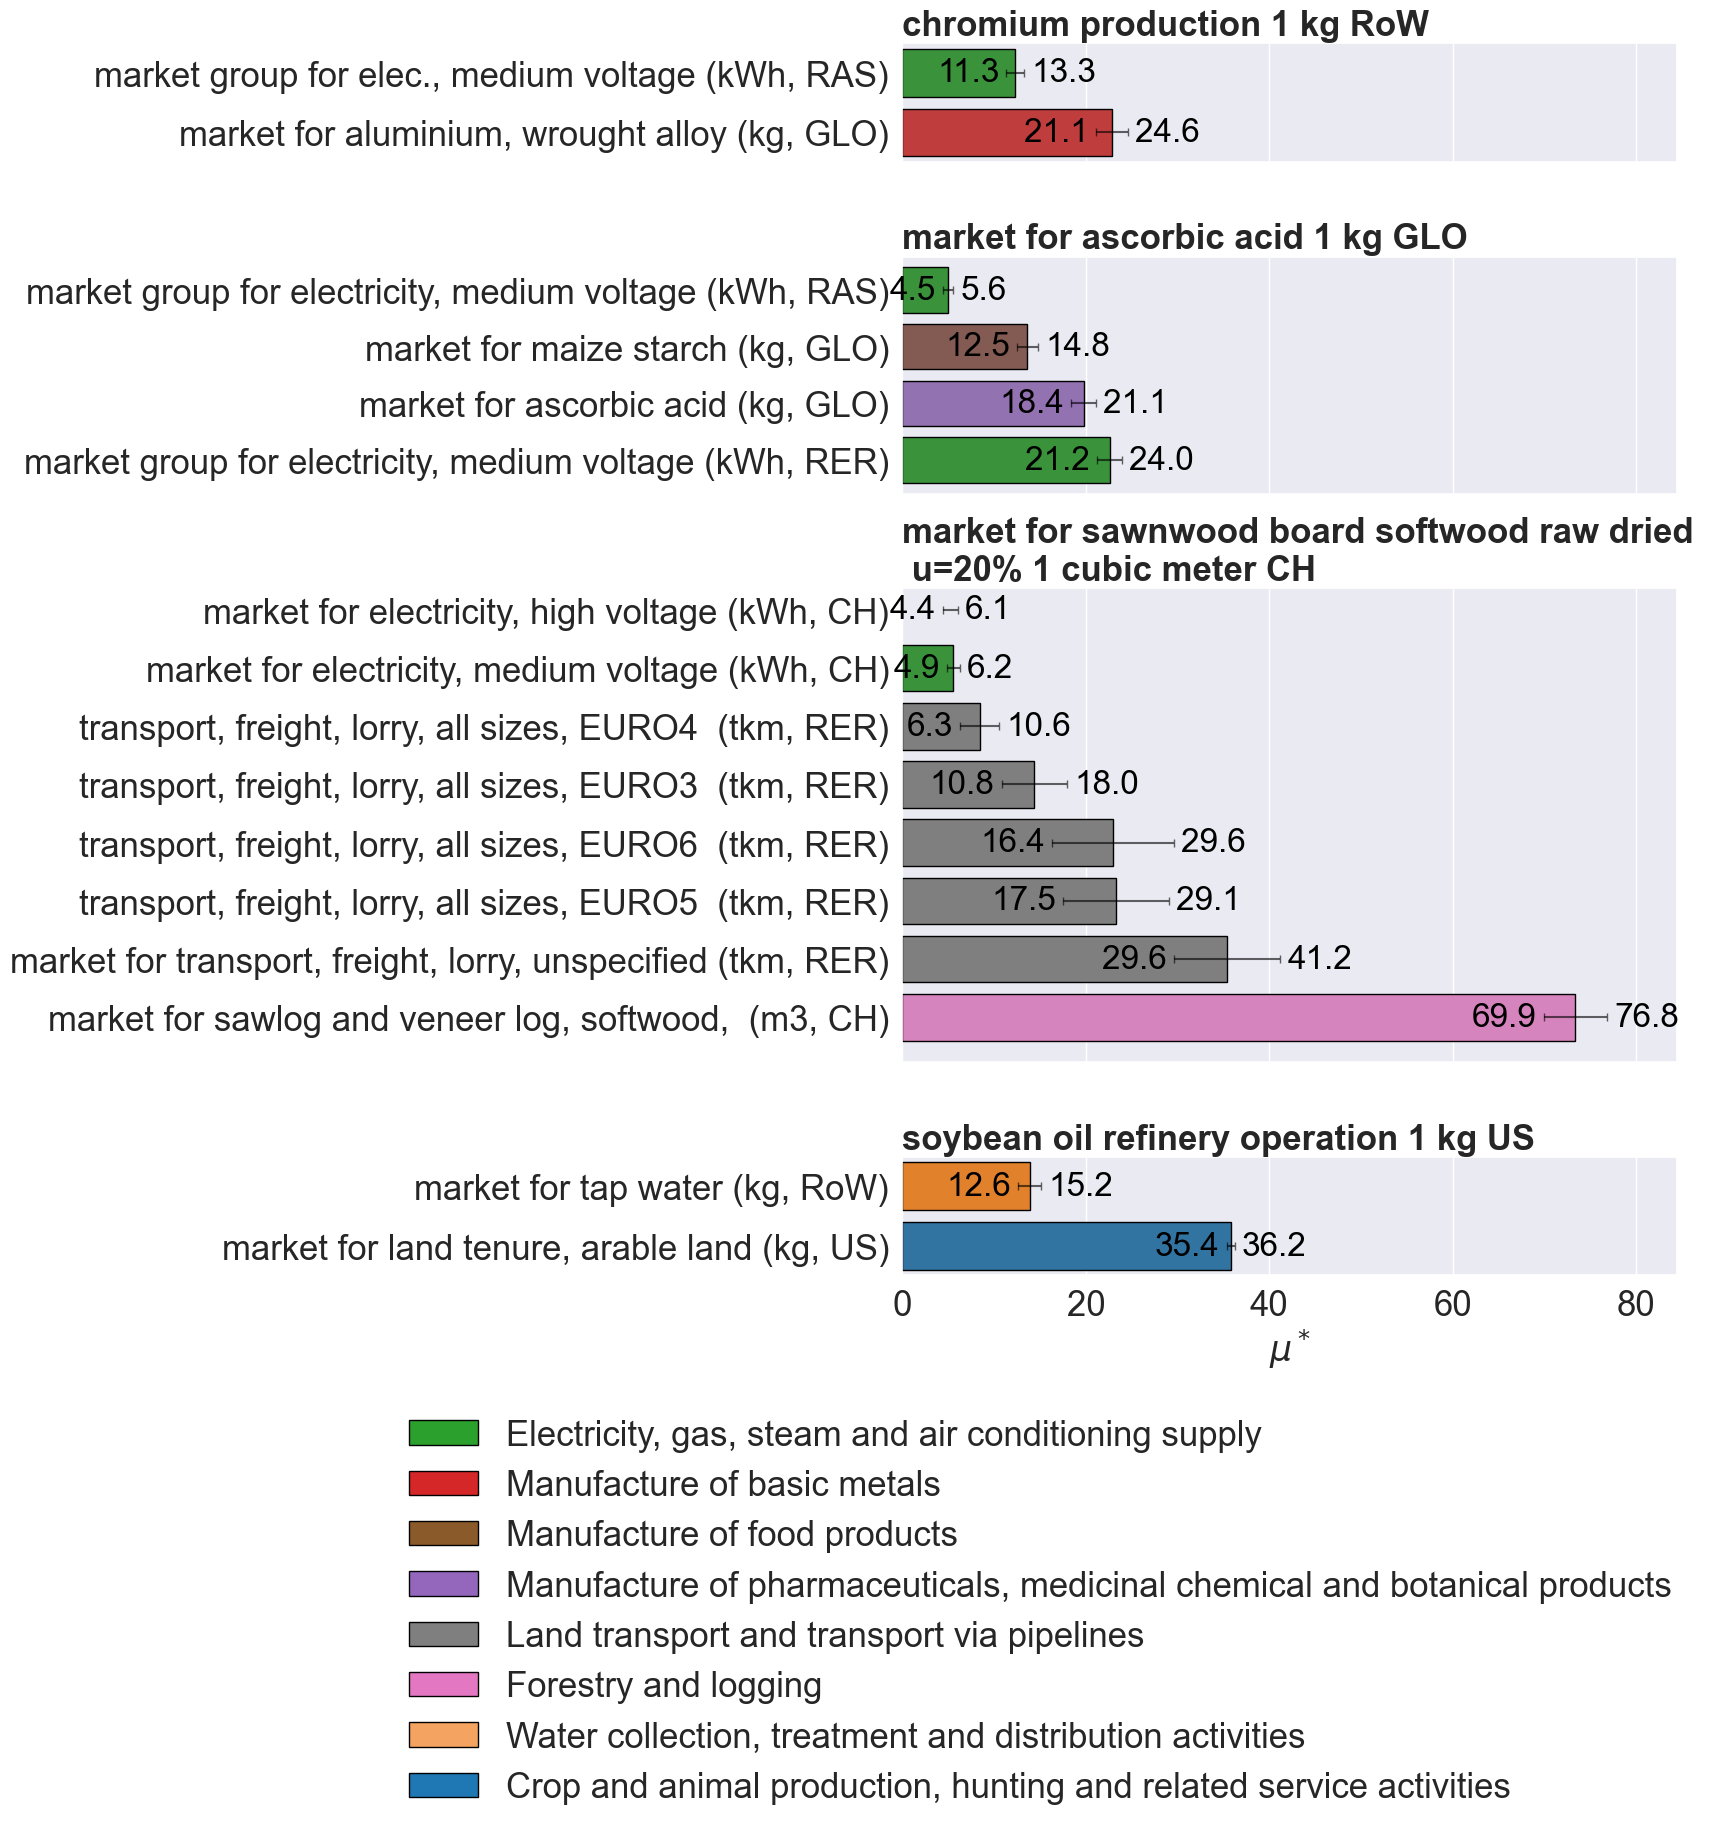

In [455]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.patches import Patch
import warnings

warnings.filterwarnings("ignore")

sns.set_style("darkgrid")
sns.set_context("notebook", font_scale=1.55) 

# Parameters
mu_star_cutoff = 5

custom_x_labels = [
    'chromium production 1 kg RoW',
    'market for ascorbic acid 1 kg GLO',
    'market for sawnwood board softwood raw dried \n u=20% 1 cubic meter CH',
    'soybean oil refinery operation 1 kg US'
]

# Step 1: Group data
grouped_data = []
max_mu_star_plus_conf = 0

for ref_product, group in products_market.groupby("reference_product"):
    filtered = group[group["mu_star_relative"] > mu_star_cutoff].dropna(
        subset=["mu_star_relative", "mu_star_conf_relative"])
    if filtered.empty:
        continue
    filtered = filtered.sort_values("mu_star_relative", ascending=True)
    grouped_data.append((ref_product, filtered))
    local_max = (filtered["mu_star_relative"] + filtered["mu_star_conf_relative"]).max()
    max_mu_star_plus_conf = max(max_mu_star_plus_conf, local_max)

unique_categories = products_market["ISIC category"].dropna().unique()
palette = sns.color_palette("tab10", len(unique_categories))
color_mapping = dict(zip(unique_categories, palette))

if not grouped_data:
    print("No data meets the mu_star cutoff criteria.")
else:
    n_plots = len(grouped_data)
    fig, axes = plt.subplots(
        n_plots, 1,
        figsize=(10, sum(len(df) for _, df in grouped_data) * 1),
        sharex=True,
        gridspec_kw={"height_ratios": [len(df) for _, df in grouped_data], "hspace": 0.4}
    )

    if n_plots == 1:
        axes = [axes]

    for ax, (ref_product, df) in zip(axes, grouped_data):
        df = df.copy()
        df["mu_min"] = df["mu_star_relative"] - df["mu_star_conf_relative"]
        df["mu_max"] = df["mu_star_relative"] + df["mu_star_conf_relative"]
        df["y_pos"] = np.arange(len(df))

        sns.barplot(
            data=df,
            y="names",
            x="mu_star_relative",
            hue="ISIC category",
            dodge=False,
            ax=ax,
            orient="h",
            palette=color_mapping,
            edgecolor='black',
            legend=False  # suppress local legend on subplots
        )

        # Add error bars and annotations
        for _, row in df.iterrows():
            mu = row["mu_star_relative"]
            conf = row["mu_star_conf_relative"]
            y_pos = row["y_pos"]

            ax.errorbar(
                x=mu, y=y_pos, xerr=conf, fmt='none',
                ecolor='black', capsize=3, alpha=0.6
            )

            ax.text(mu - conf - max_mu_star_plus_conf * 0.01, y_pos, f"{mu - conf:.1f}",
                    va='center', ha='right', fontsize=24, color='black')
            ax.text(mu + conf + max_mu_star_plus_conf * 0.01, y_pos, f"{mu + conf:.1f}",
                    va='center', ha='left', fontsize=24, color='black')

        ax.set_yticks(df["y_pos"])
        ax.set_yticklabels(df["names"], fontsize=25)
        ax.set_title(custom_x_labels.pop(0), fontweight="bold", loc="left", fontsize=25)
        ax.set_xlim(0, max_mu_star_plus_conf * 1.1)
        ax.set_xlabel(r"$\mu^*$", fontsize=25)
        ax.tick_params(axis='x', labelsize=25)
        ax.set_ylabel("")

    # Define categories and colors for legend
    legend_labels = [
        "Electricity, gas, steam and air conditioning supply",
        "Manufacture of basic metals",
        "Manufacture of food products",
        "Manufacture of pharmaceuticals, medicinal chemical and botanical products",
        "Land transport and transport via pipelines",
        "Forestry and logging",
        "Water collection, treatment and distribution activities",
        "Crop and animal production, hunting and related service activities"
    ]

    legend_colors = [
        "#2ca02c",  # green
        "#d62728",  # dark red
        "#8b5a2b",  # brown
        "#9467bd",  # purple
        "#7f7f7f",  # grey
        "#e377c2",  # pink
        "#f4a460",  # sandy
        "#1f77b4"   # blue
    ]

    legend_patches = [Patch(facecolor=color, edgecolor='black', label=label) 
                      for color, label in zip(legend_colors, legend_labels)]

    # Add the global legend to the main figure
    fig.legend(handles=legend_patches, loc='center left', bbox_to_anchor=(-0.4, -0.1), frameon=False, fontsize=25)

    plt.tight_layout(rect=[0, 0, 1, 0.95])

    # Save the figure with legend included
    fig.savefig("figures/detailed_market_scores.pdf", bbox_inches='tight')

    plt.show()


# Ecoinvent examples: recursive screening

In [407]:
Local_scores = pd.read_csv("results/Local_scores.csv")
Global_category_scores = pd.read_csv("results/Global__market_test_category_scores.csv")
Global_category_scores_to_add = pd.read_csv("results/Global__market_test_category_scores_to_add.csv")
Global_category_scores_to_add2 = pd.read_csv("results/Global__market_test_category_scores_to_add2.csv")
Global_category_scores_to_add3 = pd.read_csv("results/Global_market_for_sawnwood__board__softwood__raw__dried__u_20_____cubic_meter__CH__None_recursive_calculation.csv")
Global_category_scores_to_add4 = pd.read_csv("results/Global__market_for_sawnwood__board__softwood__raw__dried__u_20_____cubic_meter__CH__None_electricity_scores.csv")

In [408]:
Global_category_scores =   Global_category_scores_to_add3

In [409]:
import re

def clean_fu_string(raw_string, break_after=105):
    if not isinstance(raw_string, str):
        return raw_string

    cleaned = raw_string.replace("'", "")
    cleaned = cleaned.replace('_None_', '')
    cleaned = cleaned.replace('__', ' ')
    cleaned = cleaned.replace('_', ' ')
    cleaned = cleaned.strip()

    # Remove specific generic phrases
    generic_phrases = [
        "to generic market for transport freight lorry unspecified",
        "measured as solid wood under bark"
    ]
    for phrase in generic_phrases:
        cleaned = re.sub(re.escape(phrase), "", cleaned, flags=re.IGNORECASE).strip()

    # Replace long-form units with abbreviations
    unit_replacements = {
        "kilogram": "kg",
        "kilograms": "kg",
        "ton kilometer": "tkm",
        "tonne kilometer": "tkm",
        "megajoule": "MJ",
        "kilowatt hour": "kWh",
        "cubic meter": "m3",
        "square meter": "m2",
        "meter": "m",
        "second": "s",
    }
    for long, short in unit_replacements.items():
        cleaned = re.sub(rf'\b{long}\b', short, cleaned, flags=re.IGNORECASE)

    # Remove ", None" inside parentheses
    cleaned = re.sub(r',?\s*None\s*\)', ')', cleaned)

    # Insert a line break if string is longer than threshold
    if len(cleaned) > break_after:
        # Find the last space before the threshold
        break_index = cleaned.rfind(' ', 0, break_after)
        if break_index != -1:
            cleaned = cleaned[:break_index] + '\n' + cleaned[break_index+1:]

    return cleaned


In [410]:
Global_category_scores['reference_product'] = Global_category_scores['reference_product'].apply(clean_fu_string)
Global_category_scores['fu'] = Global_category_scores['fu'].apply(clean_fu_string)

In [411]:
Local_scores_1 = Local_scores.drop(columns=[  'score', 'mu_star_local'])
Global_category_scores_1 = Global_category_scores.drop(columns=['sigma', 'mu', 'mu_star_conf', 'count', 'score', 'mu_star'])

In [412]:
data =Global_category_scores_1
df_pivot = data.pivot_table(index='names', columns=['reference_product', 'fu'], values='mu_star_relative')
df_pivot = df_pivot.sort_index(axis=1, level=[0, 1])
df_pivot= df_pivot.drop(index=[
    # "Crop and animal production, hunting and related service activities",
    # "Forestry and logging",
    "Mining of coal and lignite",
    "Extraction of crude petroleum and natural gas",
    "Mining of metal ores",
    "Other mining and quarrying",
    "Manufacture of food products",
    "Manufacture of wood and products of wood and cork",
    "Manufacture of paper and paper products",
    "Repair and installation of machinery and equipment",
    "Water collection, treatment, and supply",
   "Crop and animal production, hunting and related service activities",
    # "Manufacture of coke and refined petroleum products",
    "Manufacture of chemicals and chemical products",
    "Manufacture of rubber and plastic products",
    "Manufacture of other non-metallic mineral products",
    "Manufacture of basic metals",
    "Manufacture of electrical equipment",
    "Manufacture of machinery and equipment",
    "Manufacture of fabricated metal products",
    "Manufacture of motor vehicles, trailers, and semi-trailers",
    "Manufacture of other transport equipment",
    # "Electricity, gas, steam and air conditioning supply",
    "Sewerage",
    "Unknown",
    # "Waste collection, treatment, and disposal activities",
    "Construction of buildings",
    "Civil engineering",
    "Specialized construction activities",
    "Wholesale and retail trade and repair of motor vehicles and motorcycles",
    "Wholesale trade, except of motor vehicles and motorcycles",
    # "Land transport and transport via pipelines",
    "Water transport",

])

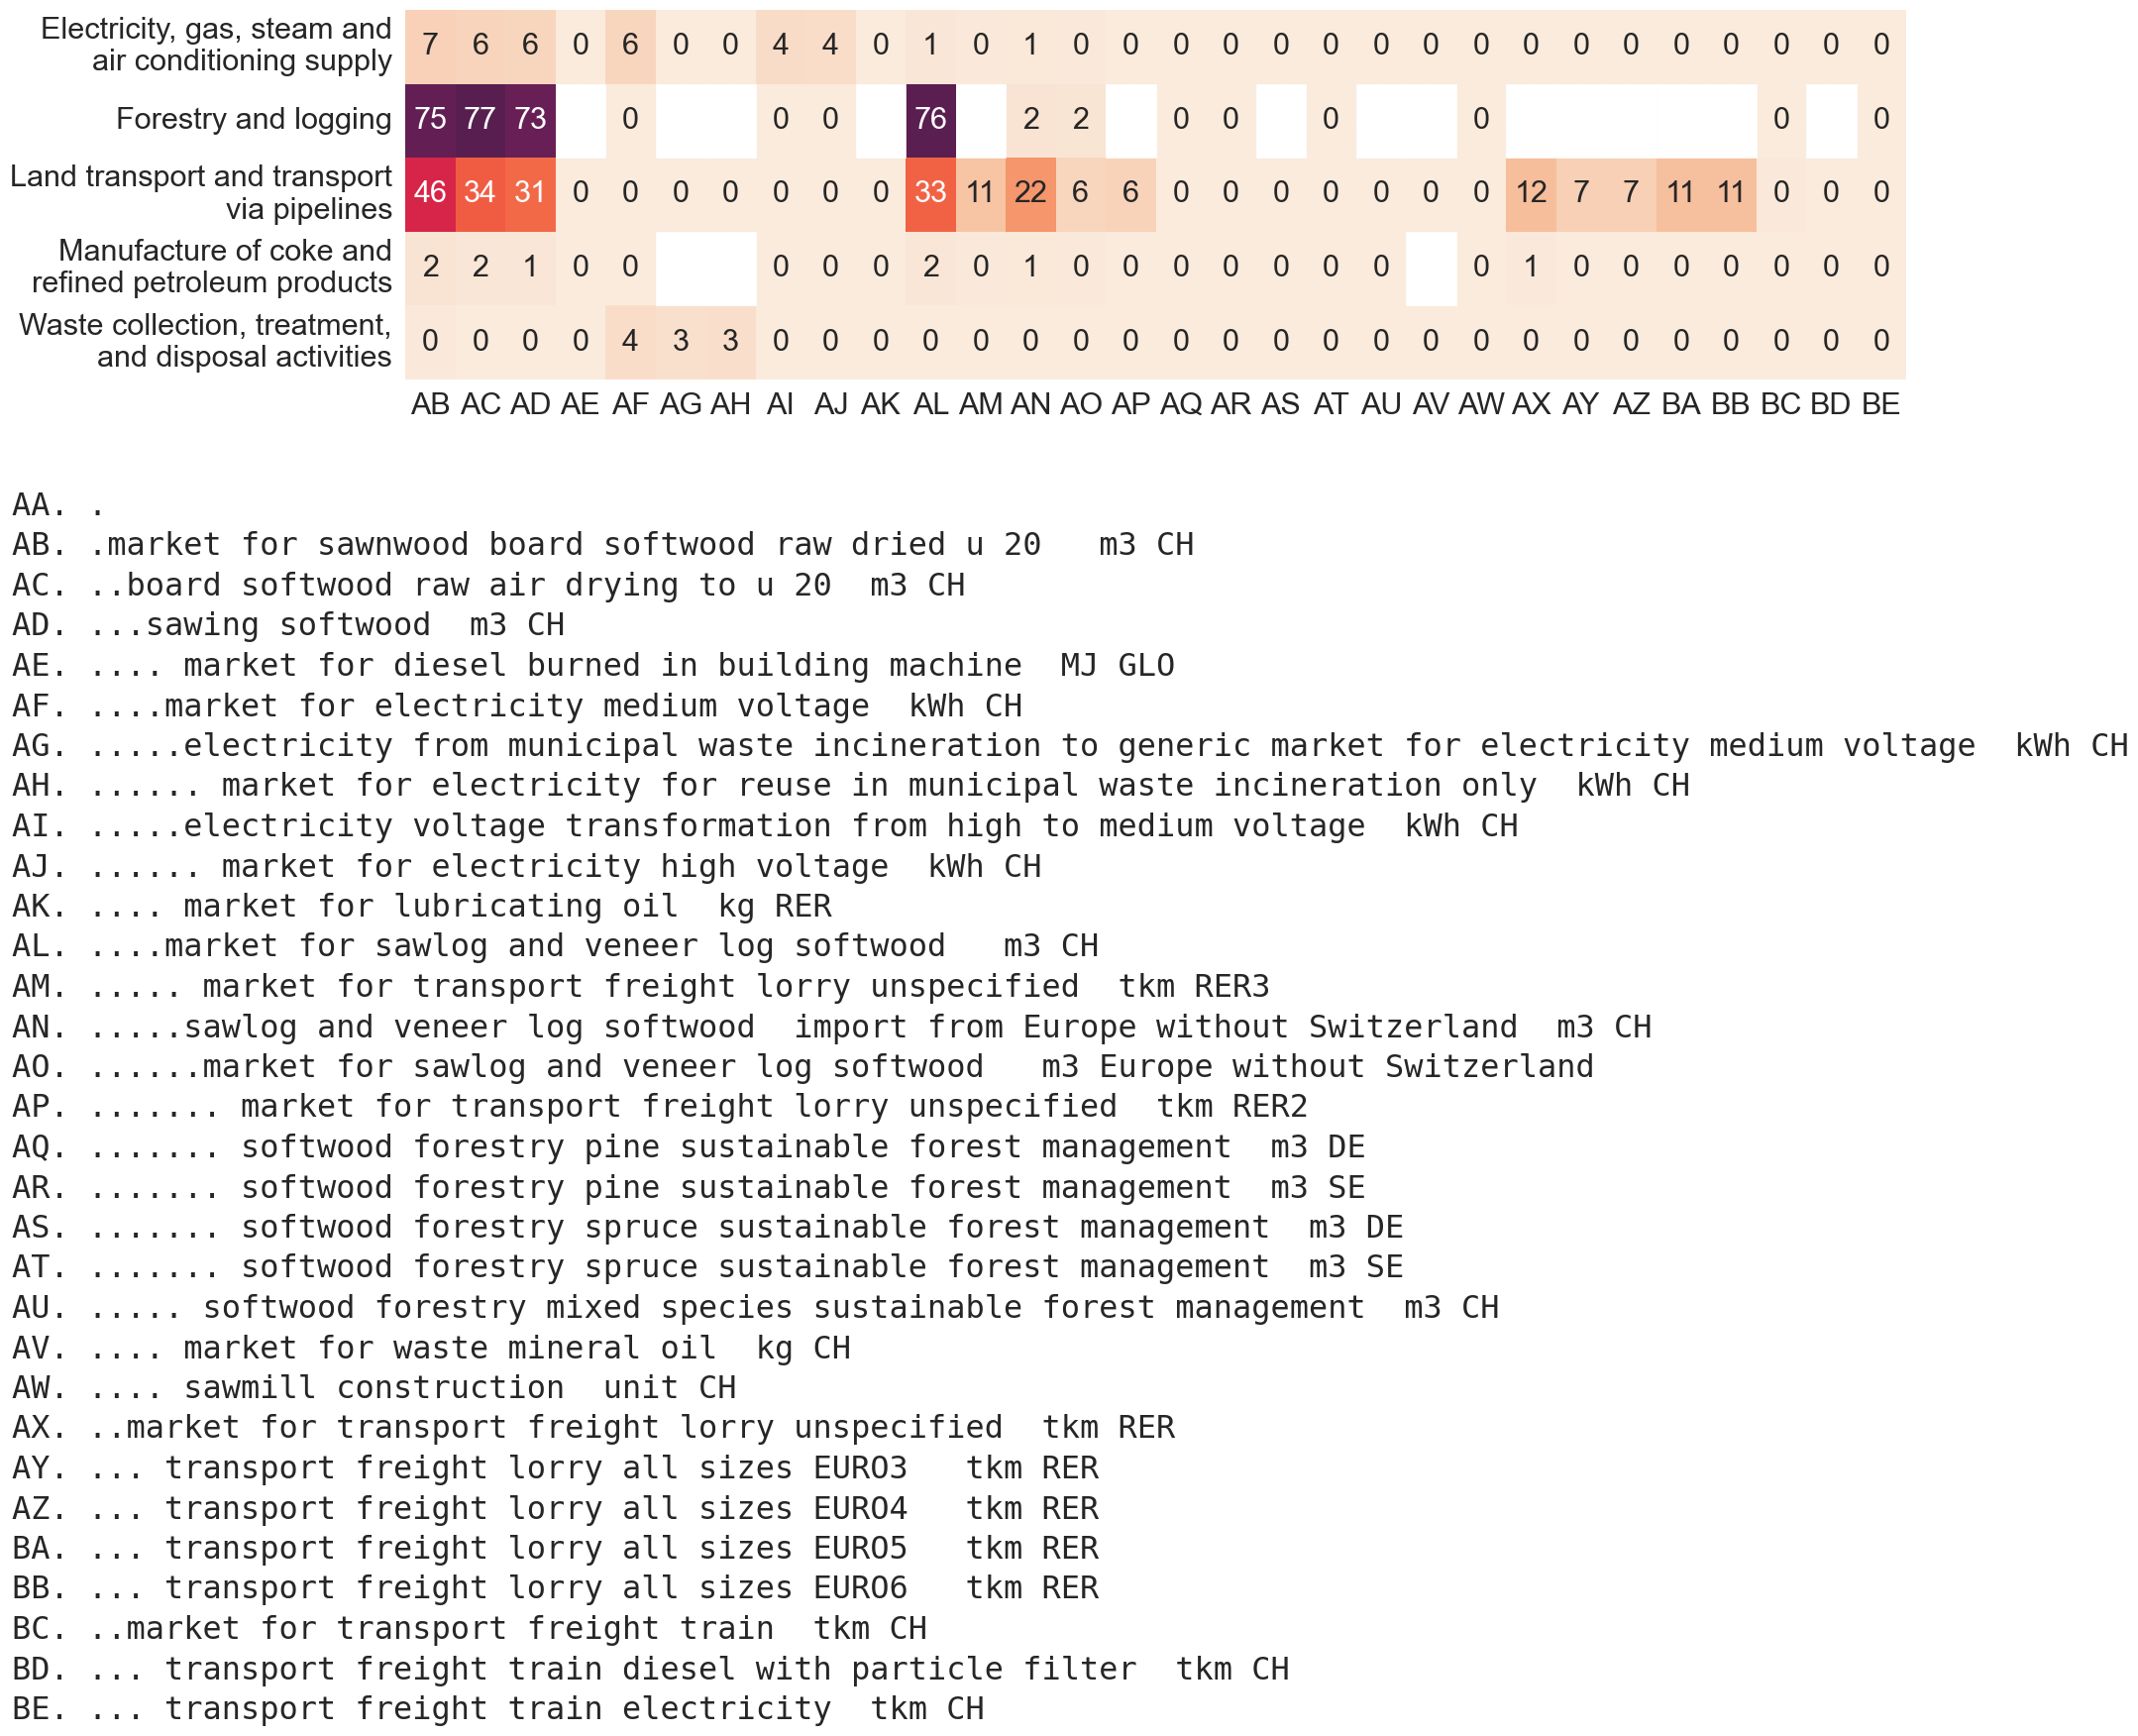

In [422]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import numpy as np
import string
from itertools import product

sns.set_style("darkgrid")
sns.set_context("notebook", font_scale=1) 

# Build the tree: reference_product → fu
tree = defaultdict(set)
for _, row in data.iterrows():
    tree[row['reference_product']].add(row['fu'])

# Create the pivot table if not already defined
if 'df_pivot' not in globals():
    df_pivot = data.pivot_table(index='names', columns=['reference_product', 'fu'], values='mu_star_relative')
    df_pivot = df_pivot.sort_index(axis=1, level=[0, 1])

# Find root nodes (reference_product that never appear as a fu)
all_parents = set(tree.keys())
all_fus = set()
for children in tree.values():
    all_fus.update(children)
roots = all_parents - all_fus

# Prepare letters for annotation
letters = list(string.ascii_uppercase)
if len(df_pivot.columns) > len(letters):
    letters = [a + b for a, b in product(string.ascii_uppercase, repeat=2)]

node_to_letter = dict()
for i, col in enumerate(df_pivot.columns):
    node_to_letter[col] = letters[i]

# Recursive legend building
def build_legend_recursive(node, depth=0):
    global letter_idx
    letter = letters[letter_idx]
    node_to_letter[node] = letter
    letter_idx += 1
    lines = [f"{letter}. {'.' * depth}{node}"]
    children = sorted(tree.get(node, []))
    for child in children:
        if child in tree:
            lines.extend(build_legend_recursive(child, depth + 1))
        else:
            letter_leaf = letters[letter_idx]
            node_to_letter[child] = letter_leaf
            letter_idx += 1
            lines.append(f"{letter_leaf}. {'.' * (depth + 1)} {child}")
    return lines

# Build legend
letter_idx = 0
legend_lines = []
for root in sorted(roots):
    legend_lines.extend(build_legend_recursive(root))

# Reorder df_pivot columns to match node_to_letter order
seen = set()
ordered_columns = []
for node in node_to_letter:
    for refprod in df_pivot.columns.get_level_values(0).unique():
        col = (refprod, node)
        if col in df_pivot.columns and col not in seen:
            ordered_columns.append(col)
            seen.add(col)

df_pivot = df_pivot[ordered_columns]

# Plot heatmap
fig, ax = plt.subplots(figsize=(max(4, len(df_pivot.columns) * 0.65), max(4.5, len(df_pivot) * 0.5)))

sns.heatmap(
    df_pivot, cmap="rocket_r", annot=True, fmt=".0f", 
    vmin=0, vmax=100, linewidth=0, linecolor="white", cbar=False, annot_kws={"size": 22},
    ax=ax
)

nan_positions = np.argwhere(np.isnan(df_pivot))
for y, x in nan_positions:
    # Rectangle coordinates: note heatmap's origin is top-left, so y is row, x is col
    rect = plt.Rectangle((x, y), 1, 1, fill=True, color='white', ec='white', lw=0.5)
    ax.add_patch(rect)
    
import textwrap

def wrap_label(label, width=30):
    # Wrap text without breaking words, respecting spaces
    return '\n'.join(textwrap.wrap(label, width=width, break_long_words=False, break_on_hyphens=False))

wrapped_y_labels = [wrap_label(label, width=30) for label in df_pivot.index]
ax.set_yticklabels(wrapped_y_labels, fontsize=21)
ax.set_ylabel("")
ax.set_xlabel("")
ax.tick_params(axis='y', labelsize=22)

fu_letters = [node_to_letter.get(fu, '?') for (_, fu) in df_pivot.columns]
ax.set_xticklabels(fu_letters, rotation=0, fontsize=22)

pos = ax.get_position()
legend_x = pos.x1 - 0.89
legend_y = pos.y1 - 1

for i, line in enumerate(legend_lines):
    fig.text(legend_x, legend_y - i * 0.09, line, va='top', ha='left', fontsize=23, family='monospace')

plt.tight_layout()
plt.show()
fig.savefig("figures/recursive_calc_categories.pdf", bbox_inches=mpl.transforms.Bbox.from_extents(-0.01, -13.2,  fig.bbox.x1 / fig.dpi, fig.bbox.y1 / fig.dpi )) 

# Fertiliser

In [405]:
Global_category_scores = pd.read_csv("results/Global__market_for_inorganic_phosphorus_fertiliser__as_P2O5___kilogram__IS__None__category_scores.csv")

In [214]:
Global_category_scores['combined'] =  Global_category_scores['reference_product'].astype(str) + Global_category_scores['tier'].astype(str) 
Global_category_scores['fus'] =  Global_category_scores['fu'].astype(str) + Global_category_scores['tier'].astype(str) 

In [215]:
Global_category_scores_1 = Global_category_scores.drop(columns=['sigma', 'mu', 'mu_star_conf', 'count', 'score', 'mu_star'])

In [216]:
merged_df = Global_category_scores_1.pivot_table(
    index='names', 
    columns=[ 'combined', 'fus'], 
    values='mu_star_relative', 
    aggfunc='first'
).fillna(0)

merged_df.columns = [f'{col}' for col in merged_df.columns]
merged_df = Global_category_scores_1.set_index(['names', 'combined', 'fus'])['mu_star_relative'].unstack(['combined', 'fus']).fillna(0)

In [217]:
merged_df= merged_df.drop(index=[
    "Crop and animal production, hunting and related service activities",
    "Forestry and logging",
    "Mining of coal and lignite",
    "Extraction of crude petroleum and natural gas",
    "Mining of metal ores",
    "Other mining and quarrying",
    "Manufacture of food products",
    "Manufacture of wood and products of wood and cork",
    # "Manufacture of paper and paper products",
    "Manufacture of coke and refined petroleum products",
    # "Manufacture of chemicals and chemical products",
    "Manufacture of rubber and plastic products",
    "Manufacture of other non-metallic mineral products",
    "Manufacture of basic metals",
    "Manufacture of electrical equipment",
    "Manufacture of machinery and equipment",
    "Manufacture of other transport equipment",
    # "Electricity, gas, steam and air conditioning supply",
    # "Sewerage",
    "Unknown",
    # "Manufacture of computer, electronic, and optical products",
    # "Manufacture of fabricated metal products",
    "Waste collection, treatment, and disposal activities",
    "Construction of buildings",
    "Civil engineering",
    "Specialized construction activities",
    "Wholesale and retail trade and repair of motor vehicles and motorcycles",
    "Wholesale trade, except of motor vehicles and motorcycles",
    # "Land transport and transport via pipelines",
    "Water transport",
])

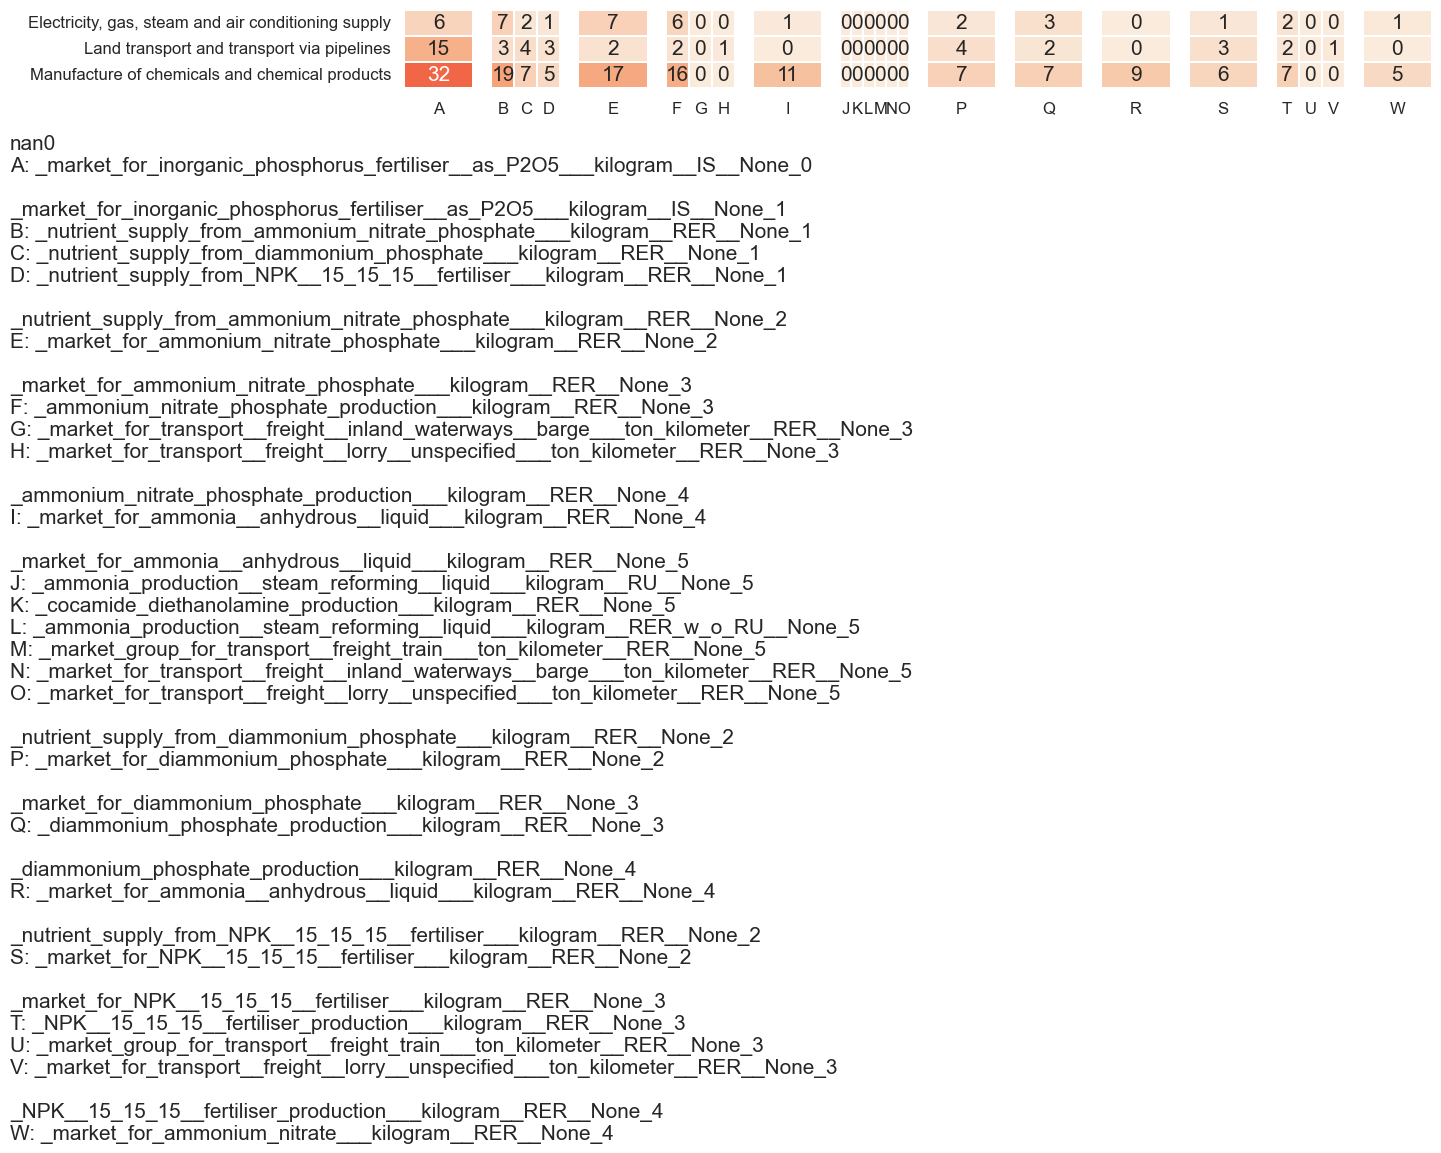

In [218]:
# Get unique reference_product values
reference_values = merged_df.columns.get_level_values('combined').unique()
n_plots = len(reference_values)

# Set up figure and axes for side-by-side plotting
fig, axes = plt.subplots(1, n_plots, figsize=(1.2* n_plots, 1.5), sharey=True)

if n_plots == 1:
    axes = [axes]  # Ensure axes is iterable when only one plot

# Initialize legend text storage
legend_texts = []
global_index = 0
# Loop over each reference_value and plot the heatmap
for i, reference_value in enumerate(reference_values):
    filtered_df = merged_df.xs(reference_value, level='combined', axis=1)

    # Plot the heatmap
    sns.heatmap(filtered_df, cmap="rocket_r", annot=True, fmt=".0f",  annot_kws={"size": 15},
                vmin=0, vmax=100, linewidth=0.3, linecolor="white", ax=axes[i], cbar=False)

    # Generate labels (A, B, C, ...) for columns
    labels = [chr(65 + (global_index + j) % 26) for j in range(len(filtered_df.columns))]
    global_index += len(filtered_df.columns)

    # Center the ticks
    axes[i].set_xticks(np.arange(len(filtered_df.columns)) + 0.5)
    axes[i].set_xticklabels(labels, ha="center", fontsize=12, rotation=0)
    axes[i].set_yticks(np.arange(len(filtered_df.index)) + 0.5)
    axes[i].set_yticklabels(filtered_df.index, va="center", fontsize=12)

    # Axis labels and title
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
   # axes[i].set_title(f"{reference_value}")

    # Create the legend text
    legend_labels = {labels[j]: filtered_df.columns[j] for j in range(len(filtered_df.columns))}
    legend_text = f"{reference_value}\n" + '\n'.join([f'{key}: {value}' for key, value in legend_labels.items()])
    legend_texts.append(legend_text)

# Plot all legends below each other
legend_full_text = '\n\n'.join(legend_texts)
fig.text(+0, 0, legend_full_text, fontsize=15, ha='left', va='top')
fig.subplots_adjust(bottom=0.8)

# Adjust layout for better display
plt.tight_layout()# Reserve space below for legends
plt.show()
fig.savefig("figures/recursive_calc_fertiliser.pdf", bbox_inches=mpl.transforms.Bbox.from_extents(-0.5, -5.5, fig.bbox.x1 / fig.dpi, fig.bbox.y1 / fig.dpi + 0.5))